In [10]:
# Stage B.2: GT vs COLMAP camera trajectory alignment & error analysis

import os
import json
import numpy as np
import matplotlib.pyplot as plt

from math import acos
from numpy.linalg import norm

# ==== 配置路径：请按你自己的实际目录修改 ====

# GT transforms.json 所在目录（Stage A 输出）
GT_DIR = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2"

# COLMAP sparse 模型目录（含 cameras.txt / images.txt / points3D.txt）
COLMAP_DIR = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_sparse"

# 输出结果目录（Stage B 输出）
OUT_DIR = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment"
os.makedirs(OUT_DIR, exist_ok=True)

print("GT_DIR    =", GT_DIR)
print("COLMAP_DIR=", COLMAP_DIR)
print("OUT_DIR   =", OUT_DIR)


GT_DIR    = /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2
COLMAP_DIR= /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_sparse
OUT_DIR   = /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment


In [11]:
def qvec_to_rotmat(qvec):
    """
    COLMAP 的四元数格式: [qw, qx, qy, qz]
    返回 3x3 旋转矩阵 R，使得：X_cam = R * X_world + t  (world→camera)
    """
    qw, qx, qy, qz = qvec
    # 归一化，防止数值误差
    nq = np.linalg.norm(qvec)
    if nq == 0:
        return np.eye(3, dtype=np.float64)
    qw, qx, qy, qz = qvec / nq

    # 标准四元数转矩阵
    R = np.array([
        [1 - 2*(qy**2 + qz**2),     2*(qx*qy - qz*qw),         2*(qx*qz + qy*qw)],
        [2*(qx*qy + qz*qw),         1 - 2*(qx**2 + qz**2),     2*(qy*qz - qx*qw)],
        [2*(qx*qz - qy*qw),         2*(qy*qz + qx*qw),         1 - 2*(qx**2 + qy**2)],
    ], dtype=np.float64)
    return R


def umeyama_alignment(src, dst, with_scale=True):
    """
    Umeyama 相似变换估计:
        src: (N,3) 源点集，例如 COLMAP 的 camera centers
        dst: (N,3) 目标点集，例如 GT 的 camera centers
    返回:
        s: 缩放因子
        R: 3x3 旋转矩阵
        t: 3D 平移向量
    满足:
        dst ≈ s * R @ src + t
    """
    src = np.asarray(src, dtype=np.float64)
    dst = np.asarray(dst, dtype=np.float64)
    assert src.shape == dst.shape
    n, m = src.shape
    assert m == 3

    # 均值
    mu_src = src.mean(axis=0)
    mu_dst = dst.mean(axis=0)

    # 去中心
    src_centered = src - mu_src
    dst_centered = dst - mu_dst

    # 协方差矩阵
    Sigma = dst_centered.T @ src_centered / n

    # SVD
    U, D, Vt = np.linalg.svd(Sigma)
    S = np.eye(3)
    if np.linalg.det(U) * np.linalg.det(Vt) < 0:
        S[-1, -1] = -1

    R = U @ S @ Vt

    if with_scale:
        var_src = (src_centered ** 2).sum() / n
        s = np.trace(np.diag(D) @ S) / var_src
    else:
        s = 1.0

    t = mu_dst - s * R @ mu_src
    return s, R, t


In [ ]:
# ==== 读取 GT 相机位姿 ====
transforms_path = os.path.join(GT_DIR, "transforms.json")
print("Using GT transforms:", transforms_path)

with open(transforms_path, "r") as f:
    meta = json.load(f)

gt_frames = meta["frames"]
print("Number of GT frames:", len(gt_frames))

# 解析 GT: filename -> (4x4 c2w)
gt_c2w_dict = {}

for frame in gt_frames:
    fp = frame["file_path"]   # e.g. "./undistorted/rgb/0000.png"
    T = np.array(frame["transform_matrix"], dtype=np.float64)  # 4x4, camera-to-world
    # 以 basename 作为 key，与 COLMAP 的 NAME 对齐
    basename = os.path.basename(fp)
    gt_c2w_dict[basename] = T

print("Example GT key:", list(gt_c2w_dict.keys())[:5])


Using GT transforms: /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/transforms.json
Number of GT frames: 617
Example GT key: ['0000.png', '0001.png', '0002.png', '0003.png', '0004.png']


In [14]:
images_txt = os.path.join(COLMAP_DIR, "images.txt")
print("Reading COLMAP images from:", images_txt)

colmap_c2w_dict = {}  # filename -> 4x4 c2w

with open(images_txt, "r") as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()
    if line.startswith("#") or len(line) == 0:
        i += 1
        continue

    # header line: IMAGE_ID qw qx qy qz tx ty tz CAMERA_ID NAME
    elems = line.split()
    if len(elems) < 10:
        i += 1
        continue

    image_id = int(elems[0])
    qw, qx, qy, qz = map(float, elems[1:5])
    tx, ty, tz = map(float, elems[5:8])
    camera_id = int(elems[8])
    name = elems[9]  # e.g. "0162.png" or "undistorted/rgb/0162.png"

    # 下一个 line 是 POINTS2D，可以直接跳过
    i += 2

    qvec = np.array([qw, qx, qy, qz], dtype=np.float64)
    tvec = np.array([tx, ty, tz], dtype=np.float64)

    # COLMAP 定义: X_cam = R * X_world + t  (world→camera)
    R_w2c = qvec_to_rotmat(qvec)
    t_w2c = tvec.reshape(3, 1)

    # 构造 4x4 world→camera
    T_w2c = np.eye(4, dtype=np.float64)
    T_w2c[:3, :3] = R_w2c
    T_w2c[:3, 3:] = t_w2c

    # camera→world = (world→camera)^{-1}
    R_c2w = R_w2c.T
    t_c2w = -R_w2c.T @ t_w2c  # (3,1)

    T_c2w = np.eye(4, dtype=np.float64)
    T_c2w[:3, :3] = R_c2w
    T_c2w[:3, 3:] = t_c2w     # 这里改成直接赋整个 (3,1)

    basename = os.path.basename(name)
    colmap_c2w_dict[basename] = T_c2w

print("Number of COLMAP registered images:", len(colmap_c2w_dict))
print("Example COLMAP key:", list(colmap_c2w_dict.keys())[:5])


Reading COLMAP images from: /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_sparse/images.txt
Number of COLMAP registered images: 617
Example COLMAP key: ['0162.png', '0178.png', '0177.png', '0161.png', '0163.png']


In [15]:
# 取 GT 和 COLMAP 都有的帧（交集）
common_names = sorted(set(gt_c2w_dict.keys()) & set(colmap_c2w_dict.keys()))
print("Common frames:", len(common_names), " / GT:", len(gt_c2w_dict), " / COLMAP:", len(colmap_c2w_dict))

if len(common_names) == 0:
    raise RuntimeError("No common filenames between GT and COLMAP! Check naming / paths.")

# 构建位置数组 (N,3)
gt_positions = []
colmap_positions = []

for name in common_names:
    T_gt = gt_c2w_dict[name]
    T_cm = colmap_c2w_dict[name]

    # camera center = 第 4 列的平移部分
    c_gt = T_gt[:3, 3]
    c_cm = T_cm[:3, 3]

    gt_positions.append(c_gt)
    colmap_positions.append(c_cm)

gt_positions = np.asarray(gt_positions)       # (N,3)
colmap_positions = np.asarray(colmap_positions)

print("gt_positions shape     :", gt_positions.shape)
print("colmap_positions shape :", colmap_positions.shape)

# 简单检查一下路径尺度
print("GT path length approx   :", np.linalg.norm(gt_positions[-1] - gt_positions[0]))
print("COLMAP path length approx:", np.linalg.norm(colmap_positions[-1] - colmap_positions[0]))


Common frames: 617  / GT: 617  / COLMAP: 617
gt_positions shape     : (617, 3)
colmap_positions shape : (617, 3)
GT path length approx   : 0.00372557936095274
COLMAP path length approx: 0.8928602212842056


In [16]:
# 使用 Umeyama 对齐 COLMAP 轨迹到 GT 轨迹
s, R_align, t_align = umeyama_alignment(colmap_positions, gt_positions, with_scale=True)

print("Estimated scale s:", s)
print("Estimated R_align:\n", R_align)
print("Estimated t_align:", t_align)

# 保存对齐参数
align_params = {
    "scale": float(s),
    "R_align": R_align.tolist(),
    "t_align": t_align.tolist(),
    "num_frames": len(common_names),
    "common_filenames": common_names,
}
with open(os.path.join(OUT_DIR, "colmap_to_gt_alignment.json"), "w") as f:
    json.dump(align_params, f, indent=2)

print("Alignment parameters saved.")


Estimated scale s: 0.004330465761430109
Estimated R_align:
 [[ 0.53029943 -0.17695044  0.82913874]
 [ 0.37374189 -0.82902986 -0.41596453]
 [ 0.76098588  0.53046963 -0.37350027]]
Estimated t_align: [-0.46723646 -0.1790355  -0.32835542]
Alignment parameters saved.


In [17]:
def apply_similarity_to_c2w(T_c2w, s, R_align, t_align):
    """
    对 camera-to-world pose 应用全局相似变换:
        X_world' = s * R_align @ X_world + t_align
    则新的相机位姿:
        R' = R_align @ R
        t' = s * R_align @ t + t_align
    """
    R = T_c2w[:3, :3]
    t = T_c2w[:3, 3]

    R_new = R_align @ R
    t_new = s * (R_align @ t) + t_align

    T_new = np.eye(4, dtype=np.float64)
    T_new[:3, :3] = R_new
    T_new[:3, 3] = t_new
    return T_new


# 生成对齐后的 COLMAP poses
colmap_c2w_aligned = {}

for name in colmap_c2w_dict:
    T_cm = colmap_c2w_dict[name]
    T_new = apply_similarity_to_c2w(T_cm, s, R_align, t_align)
    colmap_c2w_aligned[name] = T_new

print("Aligned COLMAP poses:", len(colmap_c2w_aligned))

# 保存一份对齐后的姿态（方便后续使用）
aligned_poses_path = os.path.join(OUT_DIR, "colmap_c2w_aligned.npy")
np.save(aligned_poses_path, {k: v for k, v in colmap_c2w_aligned.items()})
print("Saved aligned poses to:", aligned_poses_path)


Aligned COLMAP poses: 617
Saved aligned poses to: /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/colmap_c2w_aligned.npy


In [18]:
def rotation_angle_deg(R_rel):
    """给定 R_rel = R_gt^T @ R_est，返回夹角（度数）"""
    cos_theta = (np.trace(R_rel) - 1.0) / 2.0
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = acos(cos_theta)
    return np.degrees(theta)


trans_errors = []
rot_errors = []

for name in common_names:
    T_gt = gt_c2w_dict[name]
    T_cm = colmap_c2w_aligned[name]

    c_gt = T_gt[:3, 3]
    c_cm = T_cm[:3, 3]

    # 平移误差
    te = norm(c_gt - c_cm)
    trans_errors.append(te)

    # 旋转误差
    R_gt = T_gt[:3, :3]
    R_cm = T_cm[:3, :3]
    R_rel = R_gt.T @ R_cm
    re = rotation_angle_deg(R_rel)
    rot_errors.append(re)

trans_errors = np.asarray(trans_errors)
rot_errors = np.asarray(rot_errors)

print("Translation error stats (meters):")
print("  mean   :", trans_errors.mean())
print("  median :", np.median(trans_errors))
print("  max    :", trans_errors.max())

print("\nRotation error stats (degrees):")
print("  mean   :", rot_errors.mean())
print("  median :", np.median(rot_errors))
print("  max    :", rot_errors.max())

# 保存误差
np.save(os.path.join(OUT_DIR, "translation_errors.npy"), trans_errors)
np.save(os.path.join(OUT_DIR, "rotation_errors.npy"), rot_errors)


Translation error stats (meters):
  mean   : 0.000233371328403647
  median : 0.00021440386140789207
  max    : 0.0006480143346214579

Rotation error stats (degrees):
  mean   : 0.37633543246222295
  median : 0.0
  max    : 1.673749728186406


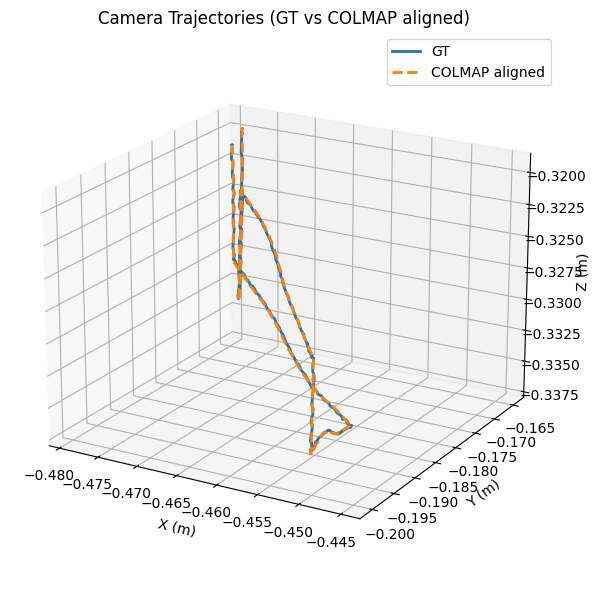

Saved trajectory figure to: /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/trajectory_gt_vs_colmap.png


In [19]:
# 构建对齐后的 COLMAP positions 数组
colmap_aligned_positions = []
for name in common_names:
    T_cm = colmap_c2w_aligned[name]
    colmap_aligned_positions.append(T_cm[:3, 3])
colmap_aligned_positions = np.asarray(colmap_aligned_positions)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(gt_positions[:, 0], gt_positions[:, 1], gt_positions[:, 2], label="GT", linewidth=2)
ax.plot(colmap_aligned_positions[:, 0], colmap_aligned_positions[:, 1], colmap_aligned_positions[:, 2],
        label="COLMAP aligned", linewidth=2, linestyle='--')

ax.set_title("Camera Trajectories (GT vs COLMAP aligned)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.legend()
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
traj_path = os.path.join(OUT_DIR, "trajectory_gt_vs_colmap.png")
plt.savefig(traj_path, dpi=200)
plt.show()

print("Saved trajectory figure to:", traj_path)


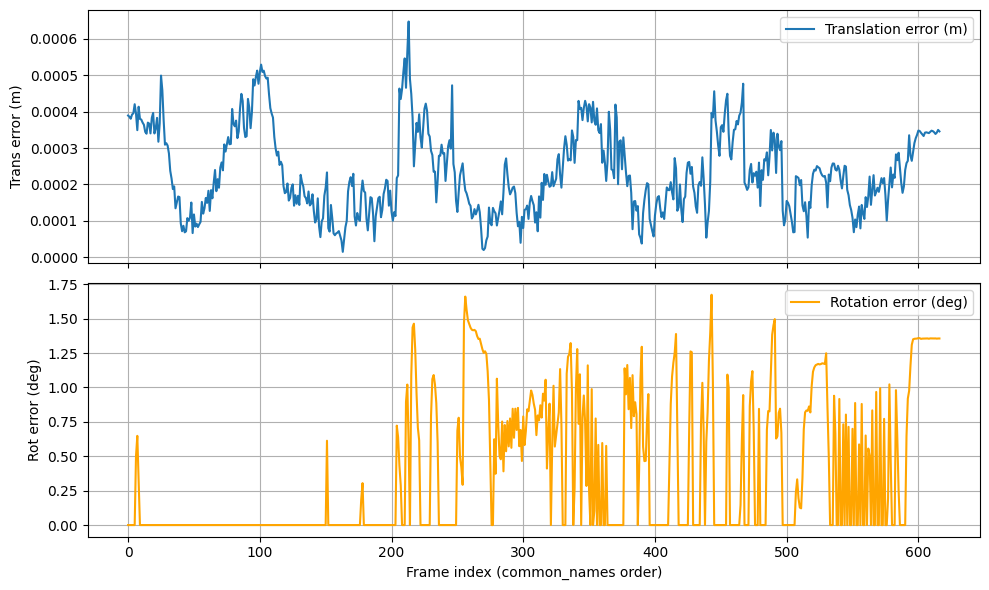

Saved error curves figure to: /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/pose_errors_curves.png


In [20]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(trans_errors, label="Translation error (m)")
axes[0].set_ylabel("Trans error (m)")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(rot_errors, label="Rotation error (deg)", color="orange")
axes[1].set_ylabel("Rot error (deg)")
axes[1].set_xlabel("Frame index (common_names order)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
err_path = os.path.join(OUT_DIR, "pose_errors_curves.png")
plt.savefig(err_path, dpi=200)
plt.show()

print("Saved error curves figure to:", err_path)


In [24]:
GT_PLY_PATH = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/gt_pointcloud_partial.ply"
ALIGN_JSON = os.path.join(OUT_DIR, "colmap_to_gt_alignment.json")
POINTS3D_TXT = os.path.join(COLMAP_DIR, "points3D.txt")

print("GT_PLY_PATH:", GT_PLY_PATH)
print("COLMAP_DIR :", COLMAP_DIR)
print("OUT_DIR    :", OUT_DIR)
print("ALIGN_JSON :", ALIGN_JSON)
print("POINTS3D   :", POINTS3D_TXT)

GT_PLY_PATH: /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/gt_pointcloud_partial.ply
COLMAP_DIR : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_sparse
OUT_DIR    : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment
ALIGN_JSON : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/colmap_to_gt_alignment.json
POINTS3D   : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_sparse/points3D.txt


In [26]:
import open3d as o3d
assert os.path.exists(GT_PLY_PATH), f"GT PLY not found: {GT_PLY_PATH}"

gt_pc = o3d.io.read_point_cloud(GT_PLY_PATH)
gt_pts = np.asarray(gt_pc.points, dtype=np.float64)
print("GT point cloud shape:", gt_pts.shape)

# 可选：如果点太多，随机下采样到最多 N 点，避免后面 NN 太慢
MAX_GT_POINTS = 150_000
if gt_pts.shape[0] > MAX_GT_POINTS:
    idx = np.random.choice(gt_pts.shape[0], MAX_GT_POINTS, replace=False)
    gt_pts = gt_pts[idx]
    gt_pc = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(gt_pts))
    print(f"GT points subsampled to: {gt_pts.shape}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
GT point cloud shape: (615000, 3)
GT points subsampled to: (150000, 3)


In [27]:
assert os.path.exists(POINTS3D_TXT), f"points3D.txt not found: {POINTS3D_TXT}"

colmap_points = []

with open(POINTS3D_TXT, "r") as f:
    for line in f:
        line = line.strip()
        if len(line) == 0 or line.startswith("#"):
            continue
        elems = line.split()
        # 格式:
        # POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[]
        if len(elems) < 8:
            continue
        x, y, z = map(float, elems[1:4])
        colmap_points.append([x, y, z])

colmap_points = np.asarray(colmap_points, dtype=np.float64)
print("COLMAP raw sparse points shape:", colmap_points.shape)

# 同样可以做个子采样（如果点过多）
MAX_COLMAP_POINTS = 150_000
if colmap_points.shape[0] > MAX_COLMAP_POINTS:
    idx = np.random.choice(colmap_points.shape[0], MAX_COLMAP_POINTS, replace=False)
    colmap_points = colmap_points[idx]
    print("COLMAP points subsampled to:", colmap_points.shape)


COLMAP raw sparse points shape: (25164, 3)


In [28]:
assert os.path.exists(ALIGN_JSON), f"Alignment json not found: {ALIGN_JSON}"

with open(ALIGN_JSON, "r") as f:
    align = json.load(f)

s = align["scale"]
R_align = np.array(align["R_align"], dtype=np.float64)
t_align = np.array(align["t_align"], dtype=np.float64)

print("Loaded alignment:")
print("  scale s:", s)
print("  R_align shape:", R_align.shape)
print("  t_align:", t_align)

# 对 COLMAP 点云做: X_gt ≈ s * R_align @ X_colmap + t_align

colmap_points_aligned = (s * (R_align @ colmap_points.T)).T + t_align[None, :]
print("Aligned COLMAP points shape:", colmap_points_aligned.shape)


Loaded alignment:
  scale s: 0.004330465761430109
  R_align shape: (3, 3)
  t_align: [-0.46723646 -0.1790355  -0.32835542]
Aligned COLMAP points shape: (25164, 3)


In [29]:
# 构造 Open3D 点云
gt_pc_for_nn = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(gt_pts))
cm_pc_for_nn = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(colmap_points_aligned))

# KDTree: GT 被当作 reference，查询 COLMAP 点到 GT 的最近邻
kdtree_gt = o3d.geometry.KDTreeFlann(gt_pc_for_nn)
kdtree_cm = o3d.geometry.KDTreeFlann(cm_pc_for_nn)

def nn_distances(query_points, kdtree, ref_points):
    """
    对每个 query 点，在 ref_points 上找最近邻，返回距离数组 (N,)
    """
    dists = np.zeros(query_points.shape[0], dtype=np.float64)
    for i, p in enumerate(query_points):
        # search_knn_vector_3d 返回: (k, idx, dist2)
        k, idx, dist2 = kdtree.search_knn_vector_3d(p, 1)
        if k > 0:
            dists[i] = np.sqrt(dist2[0])
        else:
            dists[i] = np.nan
    return dists

print("Computing COLMAP → GT distances ...")
dists_cm2gt = nn_distances(colmap_points_aligned, kdtree_gt, gt_pts)
print("Computing GT → COLMAP distances ...")
dists_gt2cm = nn_distances(gt_pts, kdtree_cm, colmap_points_aligned)

# 去掉 NaN（理论上不应该有）
dists_cm2gt = dists_cm2gt[~np.isnan(dists_cm2gt)]
dists_gt2cm = dists_gt2cm[~np.isnan(dists_gt2cm)]

print("cm2gt valid:", dists_cm2gt.shape)
print("gt2cm valid:", dists_gt2cm.shape)


Computing COLMAP → GT distances ...
Computing GT → COLMAP distances ...
cm2gt valid: (25164,)
gt2cm valid: (150000,)


In [30]:
def print_stats(name, arr):
    print(f"{name} stats (meters):")
    print("  mean   :", float(arr.mean()))
    print("  median :", float(np.median(arr)))
    print("  95%ile :", float(np.percentile(arr, 95)))
    print("  max    :", float(arr.max()))
    print()

print_stats("COLMAP → GT", dists_cm2gt)
print_stats("GT → COLMAP", dists_gt2cm)

# 一个简单的 Chamfer-like 指标（非严格定义，但足够做 baseline）
chamfer = dists_cm2gt.mean() + dists_gt2cm.mean()
print("Chamfer-like distance (mean cm2gt + mean gt2cm):", float(chamfer))


COLMAP → GT stats (meters):
  mean   : 0.004189549261622547
  median : 0.0011638704835396363
  95%ile : 0.015563909335597492
  max    : 0.700712525718274

GT → COLMAP stats (meters):
  mean   : 0.002180791745657768
  median : 0.001460468286726934
  95%ile : 0.006647353218974017
  max    : 0.013610946207874832

Chamfer-like distance (mean cm2gt + mean gt2cm): 0.006370341007280315


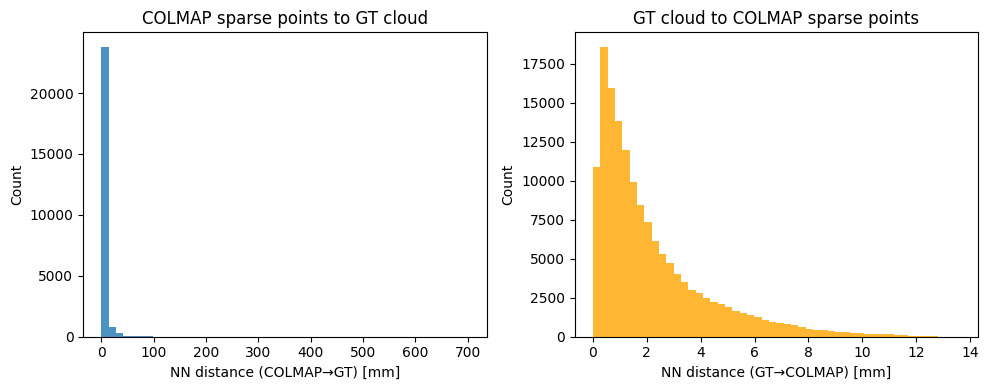

Saved histograms to: /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/pointcloud_nn_histograms.png


In [31]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(dists_cm2gt * 1000.0, bins=50, alpha=0.8)
plt.xlabel("NN distance (COLMAP→GT) [mm]")
plt.ylabel("Count")
plt.title("COLMAP sparse points to GT cloud")

plt.subplot(1, 2, 2)
plt.hist(dists_gt2cm * 1000.0, bins=50, alpha=0.8, color="orange")
plt.xlabel("NN distance (GT→COLMAP) [mm]")
plt.ylabel("Count")
plt.title("GT cloud to COLMAP sparse points")

plt.tight_layout()
hist_path = os.path.join(OUT_DIR, "pointcloud_nn_histograms.png")
plt.savefig(hist_path, dpi=200)
plt.show()

print("Saved histograms to:", hist_path)


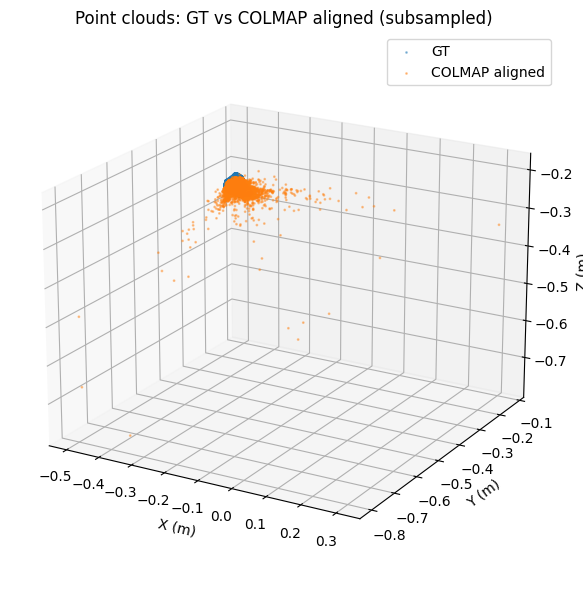

Saved 3D pointcloud figure to: /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/pointcloud_gt_vs_colmap.png


In [32]:
# 只画一小部分点，避免太密集
N_VIS_GT = min(20000, gt_pts.shape[0])
N_VIS_CM = min(20000, colmap_points_aligned.shape[0])

idx_gt = np.random.choice(gt_pts.shape[0], N_VIS_GT, replace=False)
idx_cm = np.random.choice(colmap_points_aligned.shape[0], N_VIS_CM, replace=False)

gt_vis = gt_pts[idx_gt]
cm_vis = colmap_points_aligned[idx_cm]

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(gt_vis[:, 0], gt_vis[:, 1], gt_vis[:, 2], s=1, alpha=0.4, label="GT")
ax.scatter(cm_vis[:, 0], cm_vis[:, 1], cm_vis[:, 2], s=1, alpha=0.4, label="COLMAP aligned")

ax.set_title("Point clouds: GT vs COLMAP aligned (subsampled)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.legend()
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
pc_fig_path = os.path.join(OUT_DIR, "pointcloud_gt_vs_colmap.png")
plt.savefig(pc_fig_path, dpi=200)
plt.show()

print("Saved 3D pointcloud figure to:", pc_fig_path)
